Beck, A., & Teboulle, M. (2009). A fast iterative shrinkage-thresholding algorithm for linear
inverse problems. SIAM journal on imaging sciences, 2(1), 183-202

1. ISTA的局限性：ISTA通过简单的矩阵-向量运算和阈值操作求解正则化问题，但其收敛速度较慢
2. FISTA通过引入一种基于两步更新的策略，将收敛速率提升至  O(1/k^2) 。理论分析表明，该方法在保持 ISTA 简单性的同时显著提高了效率
3. 论文通过图像去模糊的实验，比较了 ISTA、FISTA 和其他方法的性能。结果表明，FISTA 不仅理论上具有优势，实际中也能显著减少迭代次数，达到更高的精度
4. FISTA 的框架具有普适性

Chapter 2. Numerical Optimization by Jorge Nocedal and Stephen J. Wright, Springer, 2006

第2章介绍了无约束优化算法的理论基础，涵盖了经典方法（如梯度法、牛顿法）与现代改进（如拟牛顿法）

### 牛顿法和阻尼牛顿法定义

In [98]:
import torch
from torch.autograd.functional import hessian
from torch.autograd import grad

# 1. 目标函数f(x)
def objective_function(x):
    x1, x2 = x[0], x[1]
    return 10 * (x1**2 + x2**2) / 2 + 5 * torch.log(1 + torch.exp(-x1 - x2))

# 2. 计算梯度和 Hessian
def compute_gradient_and_hessian(func, x):
    # 梯度计算
    grad_f = grad(func(x), x, create_graph=True)[0]
    # Hessian 矩阵计算
    hessian_f = hessian(func, x)
    return grad_f, hessian_f

# 3. 牛顿法实现
def newton_method(func, x0, tol=1e-6, max_iter=100):
    x = x0.clone().requires_grad_(True)
    for i in range(max_iter):
        grad_f, hessian_f = compute_gradient_and_hessian(func, x)
        # 检查梯度是否满足收敛条件
        if torch.norm(grad_f) < tol:
            print(f"Converged in {i} iterations.")
            break
        # 更新规则
        inverse_hessian = torch.linalg.inv(hessian_f)  # 计算逆矩阵
        delta_x = -inverse_hessian @ grad_f           # 计算更新方向
        x = x + delta_x
    return x

# 4. 阻尼牛顿法实现
def damped_newton_method(func, x, tol=1e-6, max_iter=100, alpha=0.5, beta=0.8):
    for i in range(max_iter):
        grad_f, hessian_f = compute_gradient_and_hessian(func, x)
        if torch.norm(grad_f) < tol:
            print(f"Converged in {i} iterations.")
            break
        # 牛顿方向
        inverse_hessian = torch.linalg.inv(hessian_f)  # 计算逆矩阵
        delta_x = -inverse_hessian @ grad_f           # 计算更新方向
        t = 1.0
        # 回溯线搜索
        while func(x + t * delta_x) > func(x) + alpha * t * grad_f.dot(delta_x):
            t *= beta
        # 更新规则
        x = x + t * delta_x
    return x


x = torch.tensor([20.0, 20.0], requires_grad=True)

print("Starting Newton Method...")
x_newton = newton_method(objective_function, x)
print(f"Solution by Newton Method: {x_newton}")

print("\nStarting Damped Newton Method...")
x_damped_newton = damped_newton_method(objective_function, x)
print(f"Solution by Damped Newton Method: {x_damped_newton}")

Starting Newton Method...
Converged in 3 iterations.
Solution by Newton Method: tensor([0.2005, 0.2005], grad_fn=<AddBackward0>)

Starting Damped Newton Method...
Converged in 7 iterations.
Solution by Damped Newton Method: tensor([0.2005, 0.2005], grad_fn=<AddBackward0>)


### 调整系数

In [99]:
import torch
from torch.autograd.functional import hessian
from torch.autograd import grad

# 定义调整系数的目标函数
def coefficient_function(x, a, b):
    x1, x2 = x[0], x[1]
    return 10 * (x1**a + x2**b) / 2 + 5 * torch.log(1 + torch.exp(-x1 - x2))

# 梯度和 Hessian 的计算
def compute_gradient_and_hessian(func, x, a, b):
    grad_f = grad(func(x, a, b), x, create_graph=True)[0]
    hessian_f = hessian(lambda x: func(x, a, b), x)
    return grad_f, hessian_f

# 牛顿法
def newton_method_ab(func, x, a, b, tol=1e-6, max_iter=100):
    for i in range(max_iter):
        try:
            grad_f, hessian_f = compute_gradient_and_hessian(func, x, a, b)
            if torch.norm(grad_f) < tol:
                print(f"Newton Method converged in {i} iterations.")
                break
            # 尝试求逆
            inverse_hessian = torch.linalg.inv(hessian_f)  # 计算逆矩阵
            delta_x = -inverse_hessian @ grad_f           # 计算更新方向
            x = x + delta_x
        except torch._linalg.LinAlgError:
            print("Hessian is singular. Skipping this iteration.")
            break
        except Exception as e:
            print(f"Error in Newton Method: {e}")
            break
    return x

# 阻尼牛顿法
def damped_newton_method_ab(func, x, a, b, tol=1e-6, max_iter=100, alpha=0.5, beta=0.8):
    for i in range(max_iter):
        try:
            grad_f, hessian_f = compute_gradient_and_hessian(func, x, a, b)
            if torch.norm(grad_f) < tol:
                print(f"Damped Newton Method converged in {i} iterations.")
                break
            # 尝试求逆
            inverse_hessian = torch.linalg.inv(hessian_f)  # 计算逆矩阵
            delta_x = -inverse_hessian @ grad_f           # 计算更新方向
            t = 1.0
            while func(x + t * delta_x, a, b) > func(x, a, b) + alpha * t * grad_f.dot(delta_x):
                t *= beta
            x = x + t * delta_x
        except torch._linalg.LinAlgError:
            print("Hessian is singular. Skipping this iteration.")
            break
        except Exception as e:
            print(f"Error in Damped Newton Method: {e}")
            break
    return x

# 初始化点
x = torch.tensor([20.0, 20.0], requires_grad=True)

# 参数组合
param_combinations = [(1, 1), (2, 1), (10, 1), (1, 10), (2, 2), (100, 1), (1, 100)]

# 测试多组参数
for a, b in param_combinations:
    print(f"\nTesting with a={a}, b={b}")
    
    print("Starting Newton Method...")
    try:
        x_newton = newton_method_ab(coefficient_function, x, a, b)
        print(f"Solution by Newton Method for a={a}, b={b}: {x_newton.detach().numpy()}")
    except Exception as e:
        print(f"Error in Newton Method for a={a}, b={b}: {e}")

    print("Starting Damped Newton Method...")
    try:
        x_damped_newton = damped_newton_method_ab(coefficient_function, x, a, b)
        print(f"Solution by Damped Newton Method for a={a}, b={b}: {x_damped_newton.detach().numpy()}")
    except Exception as e:
        print(f"Error in Damped Newton Method for a={a}, b={b}: {e}")


Testing with a=1, b=1
Starting Newton Method...
Solution by Newton Method for a=1, b=1: [nan nan]
Starting Damped Newton Method...
Damped Newton Method converged in 1 iterations.
Solution by Damped Newton Method for a=1, b=1: [ 20.      -51.98262]

Testing with a=2, b=1
Starting Newton Method...
Solution by Newton Method for a=2, b=1: [nan nan]
Starting Damped Newton Method...
Error in Damped Newton Method for a=2, b=1: module 'torch' has no attribute '_linalg'

Testing with a=10, b=1
Starting Newton Method...
Solution by Newton Method for a=10, b=1: [nan nan]
Starting Damped Newton Method...
Solution by Damped Newton Method for a=10, b=1: [  0.7744585 -75.589066 ]

Testing with a=1, b=10
Starting Newton Method...
Solution by Newton Method for a=1, b=10: [nan nan]
Starting Damped Newton Method...
Solution by Damped Newton Method for a=1, b=10: [-75.589066    0.7744585]

Testing with a=2, b=2
Starting Newton Method...
Newton Method converged in 3 iterations.
Solution by Newton Method f

### 解决Rosenbrock, Beale 函数优化问题

#### 牛顿法求解

In [100]:
import torch
from torch.autograd.functional import hessian
from torch.autograd import grad

# Define the Rosenbrock function
def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

# Define the Beale function
def beale(x):
    return (1.5 - x[0] + x[0] * x[1])**2 + \
           (2.25 - x[0] + x[0] * x[1]**2)**2 + \
           (2.625 - x[0] + x[0] * x[1]**3)**2

# Initialize starting points
x0_rosen = torch.tensor([-1.5, 1.5], requires_grad=True)
x0_beale = torch.tensor([-1.0, 3.0], requires_grad=True)

# Solve Rosenbrock using Newton's Method
print("Solving Rosenbrock function with Newton's Method...")
x_newton_rosen = newton_method(rosenbrock, x0_rosen)
print(f"Solution for Rosenbrock: {x_newton_rosen.detach().numpy()}")

# Solve Beale using Newton's Method
print("\nSolving Beale function with Newton's Method...")
x_newton_beale = newton_method(beale, x0_beale)
print(f"Solution for Beale: {x_newton_beale.detach().numpy()}")

Solving Rosenbrock function with Newton's Method...


TypeError: newton_method() missing 2 required positional arguments: 'a' and 'b'

#### 可视化

Optimizing Rosenbrock Function...
Newton Method converged in 6 iterations.


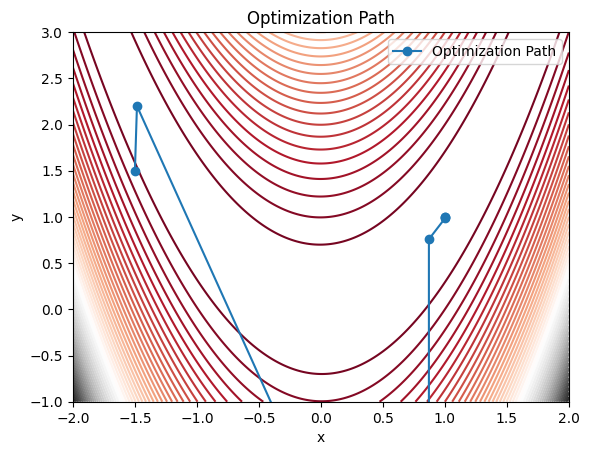

The true minimizer is: [1, 1]
The estimated minimizer is: [1. 1.]
Optimizing Beale Function...
Newton Method converged in 40 iterations.


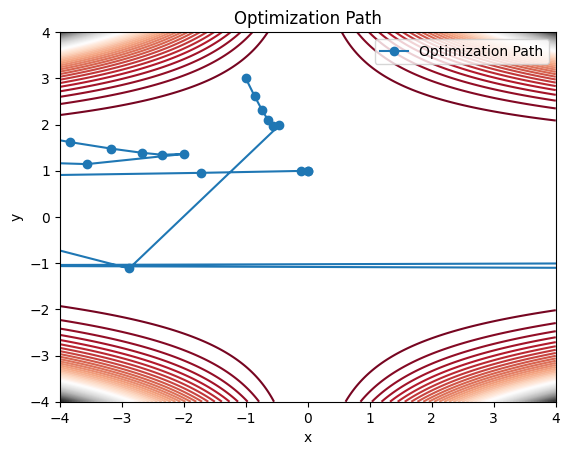

The true minimizer is: [3, 0.5]
The estimated minimizer is: [9.138603e-09 1.000000e+00]


In [86]:
import torch
from torch.autograd.functional import hessian
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt

# 牛顿法实现
def newton_method(func, params, tol=1e-6, max_iter=1000):
    obj_all = []  # 记录目标函数值
    params_all = []  # 记录每次迭代的参数值

    for i in range(max_iter):
        # 记录目标函数值和参数
        obj_val = func(None, params)  # 当前目标函数值
        obj_all.append(obj_val.item())
        params_all.append(params.detach().numpy())

        # 计算梯度和 Hessian 矩阵
        grad_f = grad(func(None, params), params, create_graph=True)[0]
        hessian_f = hessian(lambda p: func(None, p), params)

        # 检查收敛条件
        if torch.norm(grad_f) < tol:
            print(f"Newton Method converged in {i} iterations.")
            break

        # 更新方向：delta = - H^{-1} * grad
        try:
            delta = torch.linalg.solve(hessian_f, -grad_f)
        except torch._linalg.LinAlgError:
            print("Hessian is singular or ill-conditioned. Skipping iteration.")
            break

        # 更新参数
        params = params + delta

    return params.detach().numpy(), obj_all, params_all

# **Rosenbrock Function**
def rosenbrock_loss(_, params):
    return (1 - params[0])**2 + 100 * (params[1] - params[0]**2)**2

# **Beale Function**
def beale_loss(_, params):
    return ((1.5 - params[0] + params[0] * params[1])**2 +
            (2.25 - params[0] + params[0] * params[1]**2)**2 +
            (2.625 - params[0] + params[0] * params[1]**3)**2)

# **优化和绘制**
def optimize_and_plot(loss_fn, init_params, x_range, y_range, true_min):
    params = torch.tensor(init_params, requires_grad=True)

    # 使用牛顿法优化
    beta_est, obj_all, params_all = newton_method(loss_fn, params)

    # 绘制目标函数的等高线
    x = np.linspace(*x_range, 1000)
    y = np.linspace(*y_range, 1000)
    X, Y = np.meshgrid(x, y)

    if loss_fn == rosenbrock_loss:
        Z = (1 - X)**2 + 100 * (Y - X**2)**2
    elif loss_fn == beale_loss:
        Z = ((1.5 - X + X * Y)**2 +
             (2.25 - X + X * Y**2)**2 +
             (2.625 - X + X * Y**3)**2)

    plt.contour(X, Y, Z, cmap='RdGy', levels=50)
    params_all = np.array(params_all)
    plt.plot(params_all[:, 0], params_all[:, 1], '-o', label='Optimization Path')
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Optimization Path")
    plt.show()

    print(f"The true minimizer is: {true_min}")
    print(f"The estimated minimizer is: {beta_est}")

# **Rosenbrock Function Optimization**
print("Optimizing Rosenbrock Function...")
optimize_and_plot(
    rosenbrock_loss,
    init_params=[-1.5, 1.5],
    x_range=(-2, 2),
    y_range=(-1, 3),
    true_min=[1, 1]
)

# **Beale Function Optimization**
print("Optimizing Beale Function...")
optimize_and_plot(
    beale_loss,
    init_params=[-1, 3.0],
    x_range=(-4, 4),
    y_range=(-4, 4),
    true_min=[3, 0.5]
)

#### 阻尼牛顿法

In [90]:
import torch
from torch.autograd.functional import hessian
from torch.autograd import grad

def damped_newton_method(func, x, tol=1e-6, max_iter=1000, alpha=0.5, beta=0.8):
    for i in range(max_iter):
        grad_f, hessian_f = compute_gradient_and_hessian(func, x)
        if torch.norm(grad_f) < tol:
            print(f"Converged in {i} iterations.")
            break
        # 牛顿方向
        inverse_hessian = torch.linalg.inv(hessian_f)  # 计算逆矩阵
        delta_x = -inverse_hessian @ grad_f           # 计算更新方向
        t = 1.0
        # 回溯线搜索
        while func(x + t * delta_x) > func(x) + alpha * t * grad_f.dot(delta_x):
            t *= beta
        # 更新规则
        x = x + t * delta_x
    return x

# Initialize starting points
x0_rosen = torch.tensor([-1.5, 1.5], requires_grad=True)
x0_beale = torch.tensor([-1.0, 3.0], requires_grad=True)

# Solve Rosenbrock using Newton's Method
print("Solving Rosenbrock function with Newton's Method...")
x_newton_rosen = damped_newton_method(rosenbrock, x0_rosen)
print(f"Solution for Rosenbrock: {x_newton_rosen.detach().numpy()}")

# Solve Beale using Newton's Method
print("\nSolving Beale function with Newton's Method...")
x_newton_beale = damped_newton_method(beale, x0_beale)
print(f"Solution for Beale: {x_newton_beale.detach().numpy()}")

Solving Rosenbrock function with Newton's Method...
Converged in 23 iterations.
Solution for Rosenbrock: [1. 1.]

Solving Beale function with Newton's Method...
Solution for Beale: [-0.47675115  1.9833716 ]


Optimizing Rosenbrock Function with Damped Newton's Method...
Converged in 23 iterations.


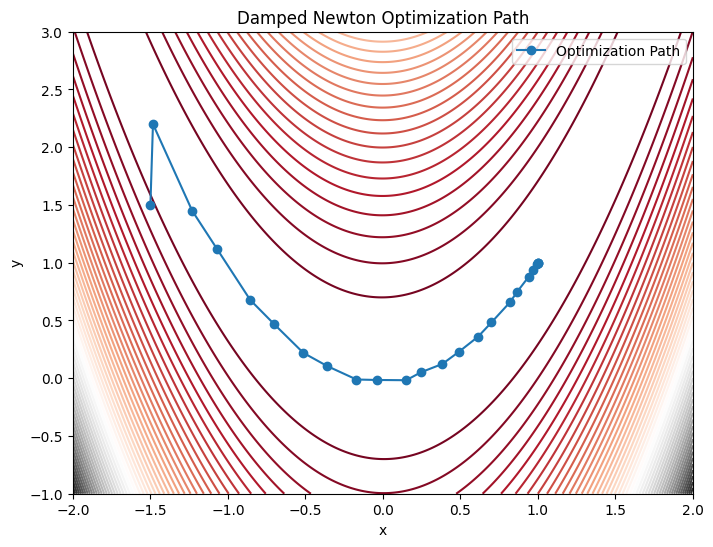

The true minimizer is: [1, 1]
The estimated minimizer is: [1. 1.]

Optimizing Beale Function with Damped Newton's Method...


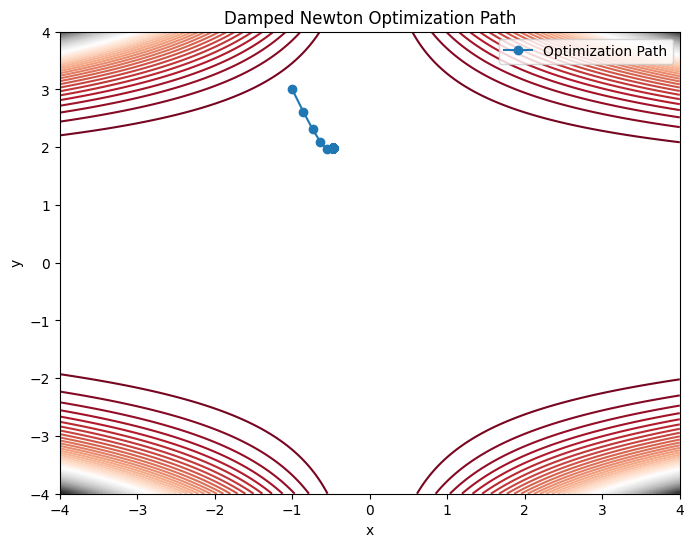

The true minimizer is: [3, 0.5]
The estimated minimizer is: [-0.47675115  1.9833716 ]


In [94]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd.functional import hessian
from torch.autograd import grad

# Define Rosenbrock and Beale functions
def rosenbrock_loss(params):
    return (1 - params[0])**2 + 100 * (params[1] - params[0]**2)**2

def beale_loss(params):
    return (1.5 - params[0] + params[0] * params[1])**2 + \
           (2.25 - params[0] + params[0] * params[1]**2)**2 + \
           (2.625 - params[0] + params[0] * params[1]**3)**2

# Compute gradient and Hessian for a function
def compute_gradient_and_hessian(func, x):
    grad_f = grad(func(x), x, create_graph=True)[0]
    hessian_f = hessian(func, x)
    return grad_f, hessian_f

# Implement Damped Newton's Method
def damped_newton_method(func, x, tol=1e-6, max_iter=1000, alpha=0.5, beta=0.8):
    obj_all = []
    params_all = [x.detach().numpy()]

    for i in range(max_iter):
        grad_f, hessian_f = compute_gradient_and_hessian(func, x)
        obj_all.append(func(x).item())

        if torch.norm(grad_f) < tol:
            print(f"Converged in {i} iterations.")
            break

        delta_x = -torch.linalg.inv(hessian_f) @ grad_f
        t = 1.0

        while func(x + t * delta_x) > func(x) + alpha * t * grad_f.dot(delta_x):
            t *= beta

        x = x + t * delta_x
        params_all.append(x.detach().numpy())

    return x.detach().numpy(), obj_all, params_all

# Visualization function
def optimize_and_plot(loss_fn, init_params, x_range, y_range, true_min):
    params = torch.tensor(init_params, dtype=torch.float32, requires_grad=True)

    # Optimize using Damped Newton's Method
    beta_est, obj_all, params_all = damped_newton_method(loss_fn, params)

    # Plot the contour of the loss function
    x = np.linspace(*x_range, 1000)
    y = np.linspace(*y_range, 1000)
    X, Y = np.meshgrid(x, y)

    if loss_fn == rosenbrock_loss:
        Z = (1 - X)**2 + 100 * (Y - X**2)**2
    elif loss_fn == beale_loss:
        Z = ((1.5 - X + X * Y)**2 +
             (2.25 - X + X * Y**2)**2 +
             (2.625 - X + X * Y**3)**2)

    plt.figure(figsize=(8, 6))
    plt.contour(X, Y, Z, cmap='RdGy', levels=50)
    params_all = np.array(params_all)
    plt.plot(params_all[:, 0], params_all[:, 1], '-o', label='Optimization Path')
    plt.xlim(*x_range)
    plt.ylim(*y_range)
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Damped Newton Optimization Path")
    plt.show()

    print(f"The true minimizer is: {true_min}")
    print(f"The estimated minimizer is: {beta_est}")

# Rosenbrock Function Optimization
print("Optimizing Rosenbrock Function with Damped Newton's Method...")
optimize_and_plot(
    rosenbrock_loss,
    init_params=[-1.5, 1.5],
    x_range=(-2, 2),
    y_range=(-1, 3),
    true_min=[1, 1]
)

# Beale Function Optimization
print("\nOptimizing Beale Function with Damped Newton's Method...")
optimize_and_plot(
    beale_loss,
    init_params=[-1, 3.0],
    x_range=(-4, 4),
    y_range=(-4, 4),
    true_min=[3, 0.5]
)